In [1]:
import string
import numbers
import math

import numpy as np
import pandas as pd
import cv2 as cv
import pprint
import scipy
import scipy.special
import scipy.spatial
import scipy.stats
import scipy.stats.qmc
import scipy.ndimage
import shapely
import shapely.geometry
import matplotlib
import matplotlib.patches
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from matplotlib.path import Path
from tabulate import tabulate
import networkx as nx

import utility as util
import utility.npu
pp = pprint.PrettyPrinter(indent=4)

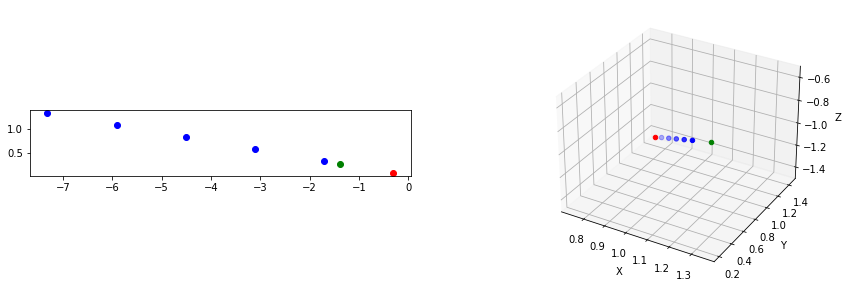

In [58]:
def extend_in_direction_by_points(p1, p2, distance=1., n=1):
    """Extend points from p1 in the direction of p2.
    The points are the same dimension, in any dimension > 1.
    
    Parameters
    ==========
    p1 : np.array
        Origin point to extend with more points.
    p2 : np.array
        Point giving the direction from p1 we want to extend with more points.
    distance : float
        The distance between each extended point.
    n : int
        Number of points to extend from p1.
    distance
    n : int
        Number of points
    
    Returns
    =======
    np.array
        The extending points.
    """
    p = (p2 - p1) / np.linalg.norm(p2 - p1)
    return p1 + util.kronecker_mul_vectors(p, np.linspace(distance, n*distance, n))

fig = plt.figure(figsize=(15, 5))

# 2D points
ax = fig.add_subplot(121)
p1, p2 = np.random.uniform(-1.5, 1.5, size=(2,2))
distance = np.random.uniform(0.1, 2.)
ps = extend_in_direction_by_points(p1, p2, distance=distance, n=5)
ax.scatter(*p1, c="r")
ax.scatter(*p2, c="g")
ax.scatter(*ps.T, c="b")
ax.set_aspect("equal")

# 3D points
ax = fig.add_subplot(122, projection='3d')
p1, p2 = np.random.uniform(-1.5, 1.5, size=(2,3))
distance = np.random.uniform(0.1, 2.)
ps = extend_in_direction_by_points(p1, p2, distance=distance, n=5)
ax.scatter(*p1, c="r")
ax.scatter(*p2, c="g")
ax.scatter(*ps.T, c="b")
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
None

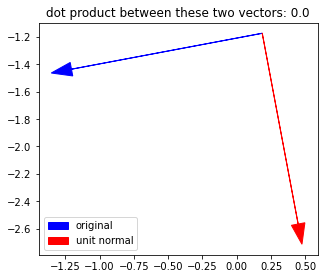

In [85]:
# get right angle direction vector from two points in 2D

p1, p2 = np.random.uniform(-1.5, 1.5, size=(2,2))
# p1 = np.array([0.1, 0.2])
# p2 = np.array([0.3, 0.3])

def unit_normal(p1, p2):
    """Compute unit normal vector to direction from p1 to p2 in 2D."""
    p = p2 - p1
    return np.array([-p[1], p[0]])

fig, ax = plt.subplots(figsize=(5, 5))
ax.arrow(*p1, *p, color="b", head_width=0.1, label="original")
ax.arrow(*p1, *_p, color="r", head_width=0.1, label="unit normal")
ax.set_aspect("equal")
ax.legend()
ax.set_title(f"dot product between these two vectors: {np.dot(_p, p)}")
None

-9.519340950342317 -3.2571696408456052


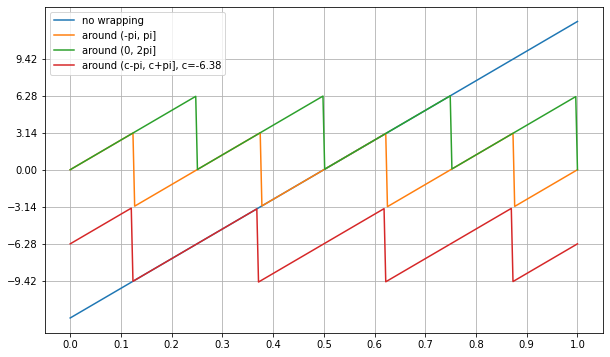

In [8]:
# warping radians

def warp_radians_neg_pi_to_pi(radians):
    """Warps radians to (-pi, pi]"""
    return (radians + np.pi) % (2 * np.pi) - np.pi

def warp_radians_0_to_2pi(radians):
    """Warps radians to [0, 2pi)"""
    return radians % (2*np.pi)

def warp_radians_about_center(radians, c):
    """Warps radians about interval (c - pi, c + pi] with center c.
    
    Parameters
    ==========
    radians : float or ndarray of float
        The radians to wrap.
    c : float
        Center of interval to wrap radians.
    
    Returns
    =======
    float of ndarray of float
        The radians wrapped.
    """
    return (radians - c + np.pi) % (2 * np.pi) + c - np.pi

domain = np.linspace(0, 1, 300)
fig, ax = plt.subplots(figsize=(10, 6))

phases = np.linspace(-4*np.pi, 4*np.pi, 300)
plt.plot(domain, phases, label="no wrapping")

phases = warp_radians_neg_pi_to_pi(phases)
plt.plot(domain, phases, label="around (-pi, pi]")

phases = warp_radians_0_to_2pi(phases)
plt.plot(domain, phases, label="around (0, 2pi]")

c = - 2*np.pi - 0.1
phases = warp_radians_about_center(phases, c)
plt.plot(domain, phases, label=f"around (c-pi, c+pi], c={np.round(c, 2)}")
print( np.min(phases), np.max(phases) )

ax = plt.gca()
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks([ -3*np.pi, -2*np.pi, -np.pi, 0, np.pi, 2*np.pi, 3*np.pi ])
ax.legend()
ax.grid()
None

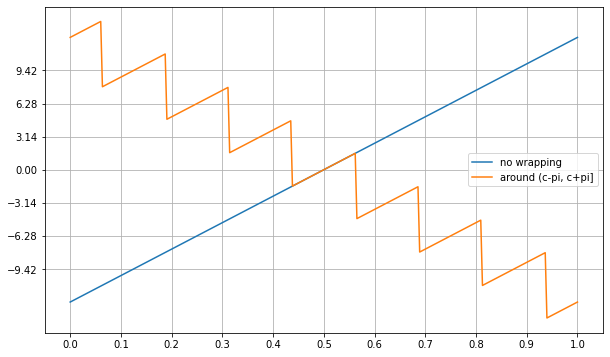

In [14]:
# warping radians, element-wise

domain = np.linspace(0, 1, 300)
fig, ax = plt.subplots(figsize=(10, 6))

phases = np.linspace(-4*np.pi, 4*np.pi, 300)
plt.plot(domain, phases, label="no wrapping")

adj_phases = np.linspace(4*np.pi, -4*np.pi, 300)
phases = warp_radians_about_center(phases, adj_phases)
plt.plot(domain, phases, label=f"around (c-pi, c+pi]")
# print( np.min(phases), np.max(phases) )

ax = plt.gca()
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks([ -3*np.pi, -2*np.pi, -np.pi, 0, np.pi, 2*np.pi, 3*np.pi ])
ax.legend()
ax.grid()

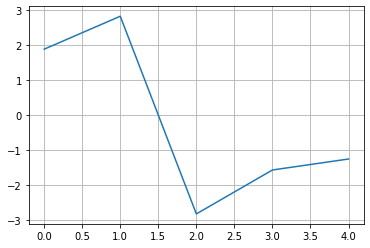

In [17]:
# Interpolate periodic linear piecewise function.

ypts = np.array([0.6, 0.9, -0.9, -0.5, -0.4]) * np.pi

ax = plt.gca()
ax.plot(range(len(ypts)), ypts)
ax.grid()

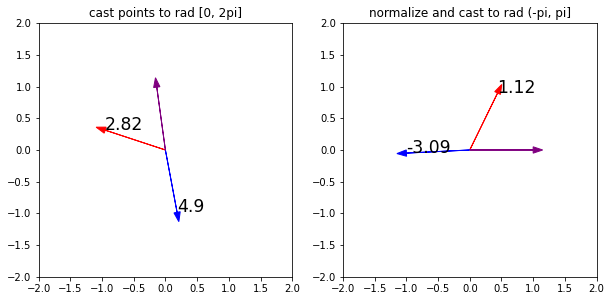

In [8]:
# reorienting arrows together such that purple arrow is aligned with +x-axis
# Note: math.atan2() and np.arctan2() give results in [-pi, pi]

def warp_radians_neg_pi_to_pi(phases):
    """Warps radians to (-pi, pi]"""
    return (phases + np.pi) % (2 * np.pi) - np.pi

def warp_radians_0_to_2pi(phases):
    return phases % (2*np.pi)

rng = np.random.default_rng()
psi_1, psi_2, psi_3 = rng.uniform(low=-4*np.pi, high=4*np.pi, size=3)

# psi_3 = psi_3 % (2*np.pi)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(121)

x_1, y_1 = math.cos(psi_1), math.sin(psi_1)
x_2, y_2 = math.cos(psi_2), math.sin(psi_2)
x_3, y_3 = math.cos(psi_3), math.sin(psi_3)
ax.arrow(0,0, x_1, y_1, color="r", head_width=0.1)
ax.arrow(0,0, x_2, y_2, color="b", head_width=0.1)
ax.arrow(0,0, x_3, y_3, color="purple", head_width=0.1)
ax.set_title("cast points to rad [0, 2pi]")

theta_1 = warp_radians_0_to_2pi(math.atan2(y_1, x_1))
theta_2 = warp_radians_0_to_2pi(math.atan2(y_2, x_2))

ax.text(x_1, y_1, np.round(theta_1, 2), size="xx-large")
ax.text(x_2, y_2, np.round(theta_2, 2), size="xx-large")

ax = fig.add_subplot(122)

ptheta_1 = theta_1 - psi_3
ptheta_2 = theta_2 - psi_3
ptheta_1 = warp_radians_neg_pi_to_pi(ptheta_1)
ptheta_2 = warp_radians_neg_pi_to_pi(ptheta_2)

x_1, y_1 = math.cos(ptheta_1), math.sin(ptheta_1)
x_2, y_2 = math.cos(ptheta_2), math.sin(ptheta_2)
ax.arrow(0,0, x_1, y_1, color="r", head_width=0.1)
ax.arrow(0,0, x_2, y_2, color="b", head_width=0.1)
ax.arrow(0,0, 1, 0, color="purple", head_width=0.1)
ax.set_title("normalize and cast to rad (-pi, pi]")

ax.text(x_1, y_1, np.round(ptheta_1, 2), size="xx-large")
ax.text(x_2, y_2, np.round(ptheta_2, 2), size="xx-large")

for ax in fig.axes:
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_aspect("equal")

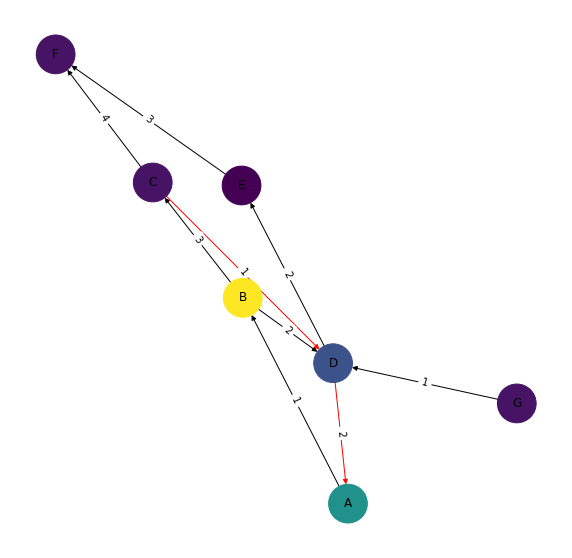

In [24]:
# Plot graph
# Based on:
# https://stackoverflow.com/questions/20133479/how-to-draw-directed-graphs-using-networkx-in-python
G = nx.DiGraph()
G.add_edges_from([('A', 'B'),('C','D'),('G','D')], weight=1)
G.add_edges_from([('D','A'),('D','E'),('B','D'),('D','E')], weight=2)
G.add_edges_from([('B','C'),('E','F')], weight=3)
G.add_edges_from([('C','F')], weight=4)


val_map = {'A': 1.0,
           'B': 2.0,
           'D': 0.5,
           'E': 0.0}

values = [val_map.get(node, 0.1) for node in G.nodes()]
edge_labels=dict([((u,v,),d['weight']) for u, v, d in G.edges(data=True)])
red_edges = [('C','D'),('D','A')]
edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

fig = plt.figure(figsize=(10, 10)); ax = fig.gca()
pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G, pos, ax=ax, node_color=values, node_size=1500, edge_color=edge_colors,
        edge_cmap=plt.cm.Reds, with_labels=True)

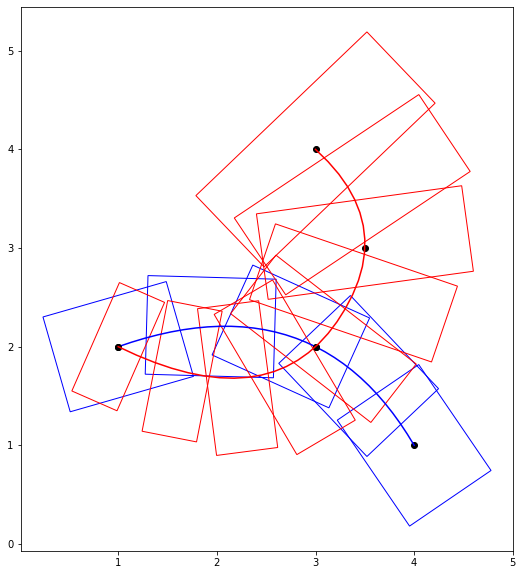

In [3]:
# Generate boxes on an interpolated spline
def get_vertices_from_centers_and_lws(centers, theta, lw):
    lws = np.repeat(lw[None], centers.shape[0], axis=0) if lw.ndim == 1 else lw
    thetas = np.full(centers.shape[0], theta) if np.ndim(theta) == 0 else theta
    C = np.cos(thetas)
    S = np.sin(thetas)
    rot11 = np.stack((-C,  S), axis=-1)
    rot12 = np.stack((-S, -C), axis=-1)
    rot21 = np.stack((-C, -S), axis=-1)
    rot22 = np.stack((-S,  C), axis=-1)
    rot31 = np.stack(( C, -S), axis=-1) 
    rot32 = np.stack(( S,  C), axis=-1)
    rot41 = np.stack(( C,  S), axis=-1)
    rot42 = np.stack(( S, -C), axis=-1)
    # Rot has shape (N, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (N, 8)
    disp = 0.5 * np.einsum("...jk, ...k ->...j", Rot, lws)
    # centers has shape (N, 8)
    centers = np.tile(centers, (4,))
    return np.reshape(centers + disp, (-1,4,2))

def interp_and_sample(points, n, interpolation='quadratic'):
    distance = np.cumsum(np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1)))
    distance = np.insert(distance, 0, 0)/distance[-1]
    interpolator =  scipy.interpolate.interp1d(distance, points, kind='quadratic', axis=0)
    return interpolator(np.linspace(0, 1, n))

def place_rectangles_on_intep_curve(points, n, lws, thetas=None, interpolation='quadratic'):
    interp_points = interp_and_sample(points, 2*n - 1, interpolation='quadratic')
    if thetas is None:
        X = interp_points[:2*n-2].reshape(-1, 2, 2).astype(complex)
        X = X[:, 1, :] - X[:, 0, :]
        X = X[:, 0] + 1j*X[:, 1]
        thetas = np.angle(X)
        X = interp_points[-2] - interp_points[-1]
        thetas = np.concatenate((thetas, [np.angle(X[0] + 1j*X[1])]))
    centers = interp_points[::2]
    return get_vertices_from_centers_and_lws(centers, thetas, lws)

fig, ax = plt.subplots(figsize=(10, 10))

points = np.array([
        [1, 2],
        [3, 2],
        [4, 1]])
ax.plot(*points.T, 'ok');
interp_points = interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-b');
vertex_set = place_rectangles_on_intep_curve(points, 5, np.array([1.3, 1]))

for vertices in vertex_set:
    patch = patches.Polygon(vertices, closed=True, color='blue', fc='none')
    ax.add_patch(patch)

points = np.array([
        [1, 2],
        [3, 2],
        [3.5, 3],
        [3, 4]])
ax.plot(*points.T, 'ok');
interp_points = interp_and_sample(points, 30)
ax.plot(*interp_points.T, '-r');
lws = util.kronecker_mul_vectors(np.array([0.5, 1.2]), np.linspace(1., 2., 9))
vertex_set = place_rectangles_on_intep_curve(points, 9, lws)

for vertices in vertex_set:
    patch = patches.Polygon(vertices, closed=True, color='red', fc='none')
    ax.add_patch(patch)

ax.set_aspect('equal')

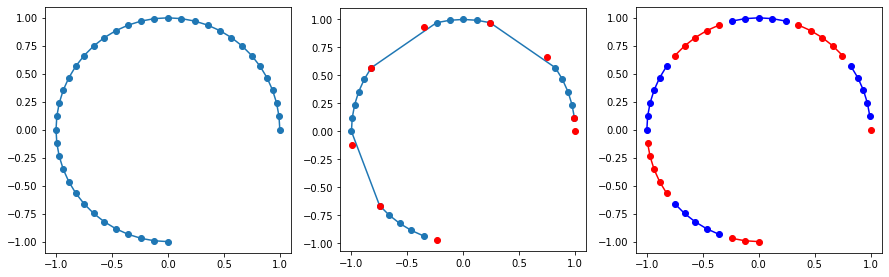

In [5]:
def split_line_by_mask(X, mask):
    # split X by inclusion or exclusion
    indices = np.where(np.diff(mask,prepend=np.nan))[0]
    l = np.split(X, indices)[1:]
    X_inclusion = l[::2] if mask[0] else l[1::2]
    X_exclusion = l[::2] if not mask[0] else l[1::2]
    return X_inclusion, X_exclusion

r = np.linspace(0, 1.5*np.pi, 40)
X = np.stack((np.cos(r), np.sin(r), np.sin(5*r)), axis=1)

mask = X[:, 2] > 0
Z = X[mask]
indices = np.where(np.diff(mask,prepend=np.nan))[0]
X_inclusion, X_exclusion = split_line_by_mask(X, mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.ravel()

axes[0].plot(X.T[0], X.T[1], '-o')

axes[1].plot(Z.T[0], Z.T[1], '-o')
axes[1].scatter(X[indices].T[0], X[indices].T[1], c='r', zorder=10)

for _X in X_inclusion:
    axes[2].plot(_X.T[0], _X.T[1], '-bo')

for _X in X_exclusion:
    axes[2].plot(_X.T[0], _X.T[1], '-ro')
    
for ax in axes:
    ax.set_aspect('equal')

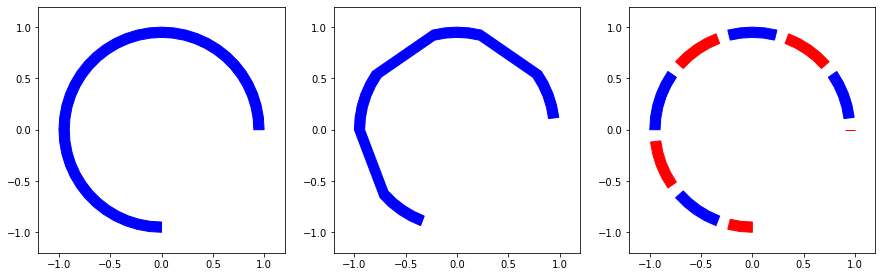

In [4]:
def split_polygon_by_mask(X, mask):
    # split X by inclusion or exclusion
    indices = np.where(np.diff(mask,prepend=np.nan))[0]
    l = np.split(X, indices)[1:]
    X_inclusion = l[::2] if mask[0] else l[1::2]
    X_exclusion = l[::2] if not mask[0] else l[1::2]
    if len(X_inclusion) % 2 == 0:
        # fold all
        n = len(X_inclusion)
        X_inclusion = util.map_to_list(np.concatenate, zip(X_inclusion[:n//2], X_inclusion[:n//2 - 1:-1]))
        # take middle and fold rest
        n = len(X_exclusion)
        X_exclusion = util.map_to_list(np.concatenate, zip(X_exclusion[:n // 2], X_exclusion[:n // 2:-1])) \
                + [X_exclusion[n // 2]]
    else:
        # take middle and fold rest
        n = len(X_inclusion)
        X_inclusion = util.map_to_list(np.concatenate, zip(X_inclusion[:n // 2], X_inclusion[:n // 2:-1])) \
                + [X_inclusion[n // 2]]
        # fold all
        n = len(X_exclusion)
        X_exclusion = util.map_to_list(np.concatenate, zip(X_exclusion[:n//2], X_exclusion[:n//2 - 1:-1]))
    return X_inclusion, X_exclusion

r = np.linspace(0, 1.5*np.pi, 40)
X1 = np.stack((np.cos(r), np.sin(r), np.sin(5*r)), axis=1)
r = np.flip(r)
X2 = np.stack((0.9*np.cos(r), 0.9*np.sin(r), np.sin(5*r)), axis=1)
X = np.concatenate((X1, X2))

mask = X[:, 2] > 0
Z = X[mask]
indices = np.where(np.diff(mask,prepend=np.nan))[0]
X_inclusion, X_exclusion = split_polygon_by_mask(X, mask)

fig, axes = plt.subplots(1, 3, figsize=(15, 10))
axes = axes.ravel()

patch = patches.Polygon(X[:, :2], color='blue'); axes[0].add_patch(patch)
patch = patches.Polygon(Z[:, :2], color='blue'); axes[1].add_patch(patch)
for _X in X_inclusion:
    patch = patches.Polygon(_X[:, :2], color='blue'); axes[2].add_patch(patch)
for _X in X_exclusion:
    patch = patches.Polygon(_X[:, :2], color='red' ); axes[2].add_patch(patch)
    
for ax in axes:
    ax.set_xlim([-1.2,1.2])
    ax.set_ylim([-1.2,1.2])
    ax.set_aspect('equal')

In [165]:
# Find indices where the values change in the array.
# Based on:
# https://stackoverflow.com/questions/19125661/find-index-where-elements-change-value-numpy
v = np.array([1, 1, 1, 1, 1, 2, 2, 2, 3, 4, 3, 4, 3, 4, 3, 4, 5, 5, 5])
indices = np.where(np.diff(v,prepend=np.nan))[0]
indices, np.split(v, indices)

(array([ 0,  5,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [array([], dtype=int64),
  array([1, 1, 1, 1, 1]),
  array([2, 2, 2]),
  array([3]),
  array([4]),
  array([3]),
  array([4]),
  array([3]),
  array([4]),
  array([3]),
  array([4]),
  array([5, 5, 5])])

In [4]:
# Printing model stats
Alphabet = tuple(k for k in string.ascii_uppercase)
scores = {
    '20210816/v3-1-1_split1_test': {
        'models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmap_modfm_ph8': {
            2: {
                'min_ade_mean': 0.05,
                'min_fde_mean': 0.13,
                'min_ade_var': 0.02,
                'min_fde_var': 0.05,
            },
            4: {
                'min_ade_mean': 0.10,
                'min_fde_mean': 0.26,
                'min_ade_var': 0.04,
                'min_fde_var': 0.10,
            },
            6: {
                'min_ade_mean': 0.30,
                'min_fde_mean': 0.52,
                'min_ade_var': 0.08,
                'min_fde_var': 0.20,
            },
            8: {
                'min_ade_mean': 0.60,
                'min_fde_mean': 1.00,
                'min_ade_var': 0.16,
                'min_fde_var': 0.50,
            },
        },
        'models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8': {
            2: {
                'min_ade_mean': 0.05,
                'min_fde_mean': 0.13,
                'min_ade_var': 0.02,
                'min_fde_var': 0.05,
            },
            4: {
                'min_ade_mean': 0.10,
                'min_fde_mean': 0.26,
                'min_ade_var': 0.04,
                'min_fde_var': 0.10,
            },
            6: {
                'min_ade_mean': 0.30,
                'min_fde_mean': 0.52,
                'min_ade_var': 0.08,
                'min_fde_var': 0.20,
            },
            8: {
                'min_ade_mean': 0.60,
                'min_fde_mean': 1.00,
                'min_ade_var': 0.16,
                'min_fde_var': 0.50,
            },
        },
        'models_17_Aug_2021_13_25_42_carla_v3-1-2_base_distmapV4_modfm_K20_ph8': {
            2: {
                'min_ade_mean': 0.05,
                'min_fde_mean': 0.13,
                'min_ade_var': 0.02,
                'min_fde_var': 0.05,
            },
            4: {
                'min_ade_mean': 0.10,
                'min_fde_mean': 0.26,
                'min_ade_var': 0.04,
                'min_fde_var': 0.10,
            },
            6: {
                'min_ade_mean': 0.30,
                'min_fde_mean': 0.52,
                'min_ade_var': 0.08,
                'min_fde_var': 0.20,
            },
            8: {
                'min_ade_mean': 0.60,
                'min_fde_mean': 1.00,
                'min_ade_var': 0.16,
                'min_fde_var': 0.50,
            },
        }
    }
}

for _experiment_name, v in scores.items():
    experiment_name, dataset_name = _experiment_name.split('/')
    print(f"Experiment {experiment_name} using dataset {dataset_name}")
    
    # Get model legend table
    headers = [f"Model Legend\nName (for experiment {experiment_name})", "\nIndex"]
    model_df = pd.DataFrame(columns=headers)
    for idx, (model_name, vv) in enumerate(v.items()):
        model_data = pd.Series({ headers[0]: model_name, headers[1]: Alphabet[idx] })
        model_df = model_df.append(model_data, ignore_index=True)
    print()
    print(tabulate(model_df, headers='keys', showindex=False, tablefmt="simple"))
    
    score_tup = [
            ("Min ADE", 'min_ade'),
            ("Min FDE", "min_fde")]
    for score_name, score_key in score_tup:
        headers  = ["\nModel", f"{score_name}\n@1s", "\n@2s", "\n@3s", "\n@4s"]
        mean_key = f"{score_key}_mean"
        var_key  = f"{score_key}_var"
    
        # Get score table
        score_df = pd.DataFrame(columns=headers)
        for idx, (model_name, vv) in enumerate(v.items()):
            score_data = { headers[0]: Alphabet[idx] }
            for jdx, (ph, vvv) in enumerate(vv.items()):
                kdx = ph // 2
                mean_val = np.around(vvv[mean_key], decimals=2 )
                dev_val  = np.around( np.sqrt(vvv[var_key]), decimals=2 )
                score_data[headers[kdx]] = f"{mean_val} +/- {dev_val}"
            model_df = model_df.append(model_data, ignore_index=True)
            score_df = score_df.append(score_data, ignore_index=True)
        print()
        print(tabulate(score_df, headers='keys', showindex=False, tablefmt="simple"))
    
    # newline
    print()

Experiment 20210816 using dataset v3-1-1_split1_test

Model Legend
Name (for experiment 20210816)                                         Index
---------------------------------------------------------------------  -------
models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmap_modfm_ph8        A
models_17_Aug_2021_13_25_38_carla_v3-1-2_base_distmapV4_modfm_K15_ph8  B
models_17_Aug_2021_13_25_42_carla_v3-1-2_base_distmapV4_modfm_K20_ph8  C

         Min ADE
Model    @1s            @2s          @3s           @4s
-------  -------------  -----------  ------------  -----------
A        0.05 +/- 0.14  0.1 +/- 0.2  0.3 +/- 0.28  0.6 +/- 0.4
B        0.05 +/- 0.14  0.1 +/- 0.2  0.3 +/- 0.28  0.6 +/- 0.4
C        0.05 +/- 0.14  0.1 +/- 0.2  0.3 +/- 0.28  0.6 +/- 0.4

         Min FDE
Model    @1s            @2s            @3s            @4s
-------  -------------  -------------  -------------  ------------
A        0.13 +/- 0.22  0.26 +/- 0.32  0.52 +/- 0.45  1.0 +/- 0.71
B        0.13 +/- 0.22 

min and max values of KDE values 3.9983968016450756e-35 1.8854100830811054
min and max values of negative log KDE values -0.6341453479454078 79.20458477360197


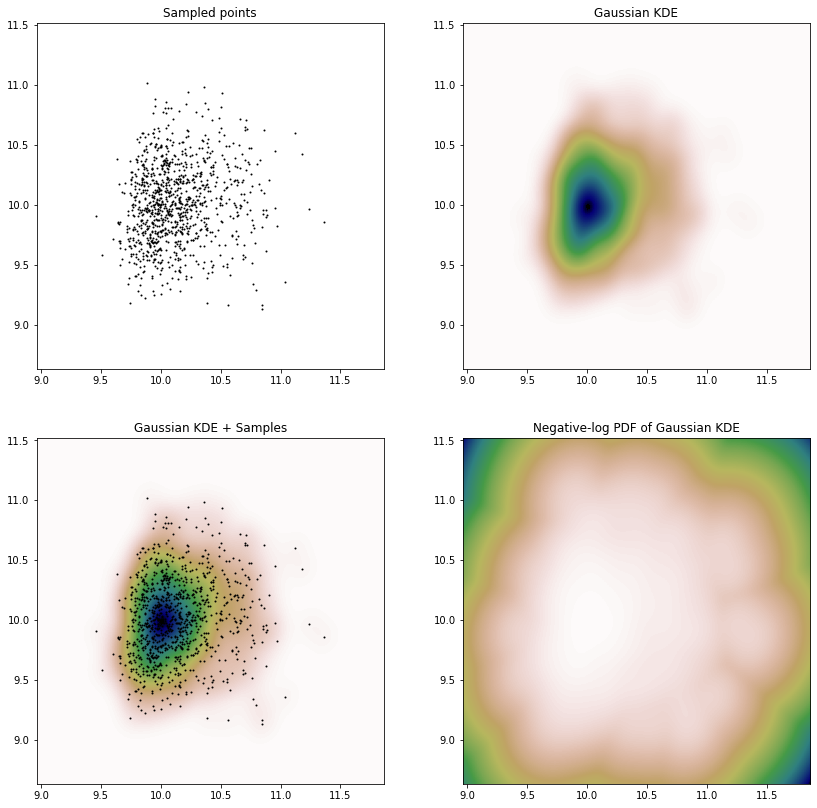

In [3]:
# How to transform a Gaussian distribution to any arbitrary distribution using ReLUs
# Fit Gaussian KDE from data. Note KDE density is not normalized [0,1]. 

def relu(x):
    return  x * (x > 0)

fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.ravel()

# Compute the samples
cov = np.array([[0.1, 0],[0, 0.1]])
mean = np.array([0, 0])
dist = scipy.stats.multivariate_normal(mean, cov)
N = 1000
X = dist.rvs(N)
Z0 = (relu(-X[:,0])*0.4) + (relu( X[:,0] - 0.3)*0.4) + (relu(-X[:,0] - 0.3)*0.15)
Z1 = (relu(X[:,1] + 0.5)*0.1)
X = np.stack((X.T[0] + Z0 + Z1 + 10, X.T[1] + 10,), axis=-1)

# Plot the samples
axes[0].scatter(X.T[0], X.T[1], s=1, c='k')
axes[2].scatter(X.T[0], X.T[1], s=1, c='k')

# Compute the KDE
kernel = scipy.stats.gaussian_kde(X.T)
M = 200
Xmin = np.min(X - 0.5,axis=0)
Xmax = np.max(X + 0.5,axis=0)
X = np.linspace(Xmin[0], Xmax[0], M)
Y = np.linspace(Xmin[1], Xmax[1], M)
X, Y = np.meshgrid(X, Y)
pos = np.vstack([X.ravel(), Y.ravel()])
# Get the KDE estimate at points pos
Z = kernel(pos)
Zp = -kernel.logpdf(pos)
print("min and max values of KDE values", np.min(Z), np.max(Z))
print("min and max values of negative log KDE values", np.min(Zp), np.max(Zp))
Z = np.reshape(Z, X.shape)
Zp = np.reshape(Zp, X.shape)

# Plot the KDE
axes[1].imshow(Z, origin='lower', cmap=plt.cm.gist_earth_r,
          extent=[Xmin[0], Xmax[0], Xmin[1], Xmax[1]])
axes[2].imshow(Z, origin='lower', cmap=plt.cm.gist_earth_r,
          extent=[Xmin[0], Xmax[0], Xmin[1], Xmax[1]])
axes[3].imshow(Zp, origin='lower', cmap=plt.cm.gist_earth_r,
          extent=[Xmin[0], Xmax[0], Xmin[1], Xmax[1]])
axes[0].set_title("Sampled points")
axes[1].set_title("Gaussian KDE")
axes[2].set_title("Gaussian KDE + Samples")
axes[3].set_title("Negative-log PDF of Gaussian KDE")

for ax in axes:
    ax.set_xlim([Xmin[0], Xmax[0]])
    ax.set_ylim([Xmin[1], Xmax[1]])
    ax.set_aspect('equal')

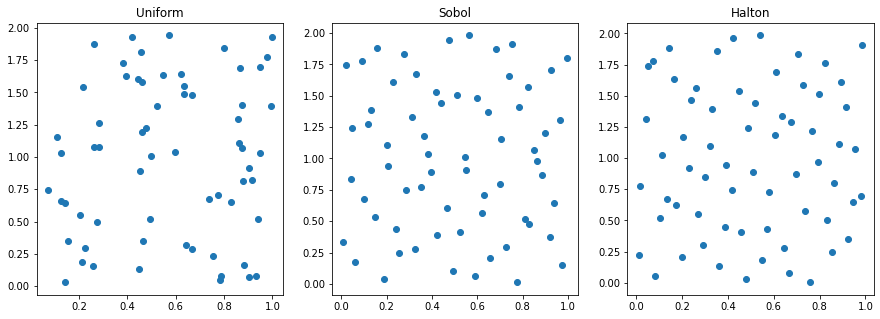

In [33]:
# Generating random numbers that are nicely spaced out using Quasi-Monte Carlo
# Based on:
# https://docs.scipy.org/doc/scipy/reference/reference/stats.qmc.html

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

X = np.random.uniform(low=(0.0, 0.0), high=(1.0, 2.0), size=(64,2))

axes[0].scatter(X[:,0], X[:,1])
axes[0].set_title("Uniform")

sampler = scipy.stats.qmc.Sobol(2)
X = sampler.random(64)
X = scipy.stats.qmc.scale(X, (0,0,), (1,2,))

axes[1].scatter(X[:,0], X[:,1])
axes[1].set_title("Sobol")

sampler = scipy.stats.qmc.Halton(2)
X = sampler.random(64)
X = scipy.stats.qmc.scale(X, (0,0,), (1,2,))

axes[2].scatter(X[:,0], X[:,1])
axes[2].set_title("Halton")
None

(0.0, 3.0)

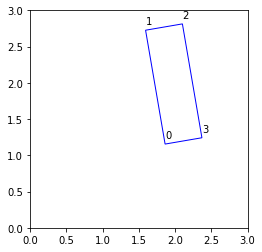

In [129]:
## Orientation of vertices of box

def get_vertices_from_center(center, heading, lw):
    vertices = np.empty((4,2))
    rot1 = np.array([
            [-np.cos(heading),  np.sin(heading)],
            [-np.sin(heading), -np.cos(heading)]])
    rot2 = np.array([
            [-np.cos(heading), -np.sin(heading)],
            [-np.sin(heading),  np.cos(heading)]])
    rot3 = np.array([
            [ np.cos(heading), -np.sin(heading)],
            [ np.sin(heading),  np.cos(heading)]])
    rot4 = np.array([
            [ np.cos(heading),  np.sin(heading)],
            [ np.sin(heading), -np.cos(heading)]])
    vertices[0] = center + 0.5 * rot1 @ lw
    vertices[1] = center + 0.5 * rot2 @ lw
    vertices[2] = center + 0.5 * rot3 @ lw
    vertices[3] = center + 0.5 * rot4 @ lw
    return vertices

theta = np.random.uniform(-np.pi, np.pi)
center = np.random.uniform(1, 2, size=2)
lw = np.random.uniform(0.5, 2.0, size=2)
vertices = get_vertices_from_center(center, theta, lw)
ax = plt.gca()
patch = patches.Polygon(vertices, fill=False, color='b')
ax.add_patch(patch)
for idx, (x, y) in enumerate(vertices):
    ax.text(x, y + 0.08, idx)
ax.set_aspect('equal')
ax.set_xlim([0, 3])
ax.set_ylim([0, 3])

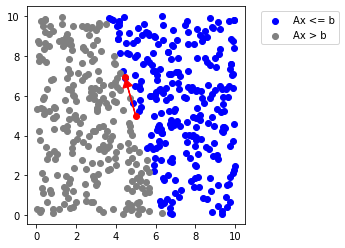

In [3]:
# Two points to halfspace. Dividing points in R^2 by the halfspace.

ax = plt.gca()

theta = np.random.uniform(-np.pi, np.pi)
P = np.array([[0,0], [2*np.cos(theta), 2*np.sin(theta)]]) + np.array([5, 5])
ax.arrow(5, 5, 1.9*np.cos(theta), 1.9*np.sin(theta),
         length_includes_head=True, head_width=0.5, head_length=0.4, color='red')

p1, p2 = P
p11, p12 = p1
p21, p22 = p2
A = np.array([p12-p22, p21-p11])
b = (p12 - p22)*p11 + (p21 - p11)*p12

N = 500
X = np.random.uniform(low=(0, 0), high=(10, 10), size=(N,2))

Z1 = X[X @ A.T <= b]
Z2 = X[X @ A.T > b]

ax.plot(P.T[0], P.T[1], '-ro')
ax.scatter(Z1.T[0], Z1.T[1], color='b', label='Ax <= b')
ax.scatter(Z2.T[0], Z2.T[1], color='grey', label='Ax > b')
ax.set_aspect('equal')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
None

(400, 2)


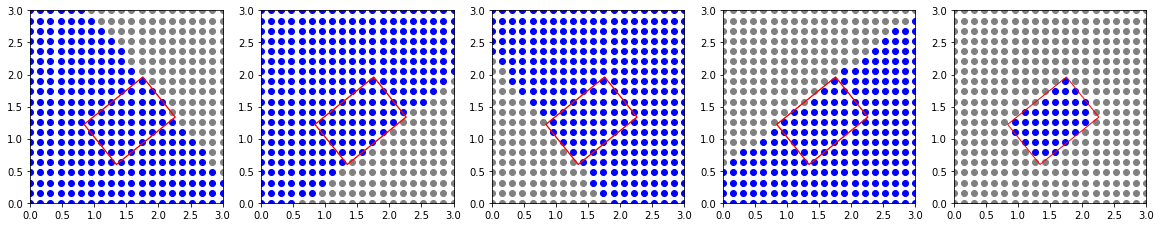

In [6]:
## Box to halfspace intersection

def pairs2d_to_halfspace(p1, p2):
    """Get half-space representation dividing the left side and the right side
    of the line formed by two points in R^2. The points x where Ax <= b are on
    the right side of the arrow from p1 to p2.
    
     x_2
      ^
      |  \
      |   \  Ax > b
      |    p1
    --|-----\------> x_1
      |      p2
     Ax <= b  \
      |        \

    Parameters
    ==========
    p1 : ndarray
        First point
    p2 : ndarray
        Second point
    
    Returns
    =======
    np.array
        A where Ax <= b
    int
        b where Ax <= b
    
    """
    p11, p12 = p1
    p21, p22 = p2
    A = np.array([p12-p22, p21-p11])
    b = (p12 - p22)*p11 + (p21 - p11)*p12
    return A, b

def vertices_to_halfspace_representation(vertices):
    """Vertices of convex polytope to half-space representation (A, b).
    where points x, A x <= b are inside the polytope. 
    
    Parameters
    ==========
    vertices : np.array
        Vertices of convex polytope of shape (N, 2) where N is the number of vertices.
        The vertices are sorted in clockwise order along the first axis and N > 2.
        
    Returns
    =======
    np.array
        A where x, Ax <= b are the points of the polytope 
    np.array
        b where x, Ax <= b are the points of the polytope
    """
    vertices = np.concatenate((vertices, vertices[0][None],), axis=0)
    A = []; b = []
    for p1, p2 in util.pairwise(vertices):
        _A, _b = pairs2d_to_halfspace(p1, p2)
        A.append(_A); b.append(_b)
    A = np.stack(A); b = np.array(b)
    return A, b

def get_vertices_from_center(center, heading, lw):
    vertices = np.empty((4,2))
    rot1 = np.array([
            [-np.cos(heading),  np.sin(heading)],
            [-np.sin(heading), -np.cos(heading)]])
    rot2 = np.array([
            [-np.cos(heading), -np.sin(heading)],
            [-np.sin(heading),  np.cos(heading)]])
    rot3 = np.array([
            [ np.cos(heading), -np.sin(heading)],
            [ np.sin(heading),  np.cos(heading)]])
    rot4 = np.array([
            [ np.cos(heading),  np.sin(heading)],
            [ np.sin(heading), -np.cos(heading)]])
    vertices[0] = center + 0.5 * rot1 @ lw
    vertices[1] = center + 0.5 * rot2 @ lw
    vertices[2] = center + 0.5 * rot3 @ lw
    vertices[3] = center + 0.5 * rot4 @ lw
    return vertices

theta = np.random.uniform(-np.pi, np.pi)
center = np.random.uniform(1, 2, size=2)
lw = np.random.uniform(0.5, 2.0, size=2)

vertices = get_vertices_from_center(center, theta, lw)
A, b = vertices_to_halfspace_representation(vertices)
X = np.linspace(0, 3, 20)
Y = np.linspace(0, 3, 20)
X = np.stack(np.meshgrid(X, Y)).reshape(2, -1).T
print(X.shape)

fig, axes = plt.subplots(1, b.size + 1, figsize=(20, 10))
axes = axes.ravel()

for idx, ax in enumerate(axes[:b.size]):
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)

    T = X @ A[idx] <= b[idx]
    Z1 = X[T]
    ax.scatter(Z1.T[0], Z1.T[1], color='b')
    T = X @ A[idx] > b[idx]
    Z2 = X[T]
    ax.scatter(Z2.T[0], Z2.T[1], color='grey')

T = np.all(X @ A.T <= b, axis=-1)
Z1 = X[T]
axes[4].scatter(Z1.T[0], Z1.T[1], color='b')
T = np.any(X @ A.T > b, axis=-1)
Z2 = X[T]
axes[4].scatter(Z2.T[0], Z2.T[1], color='grey')

for ax in axes:
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)
    ax.set_aspect('equal')
    ax.set_xlim([0, 3])
    ax.set_ylim([0, 3])

(400, 2)
(3, 4, 2) (3, 4)


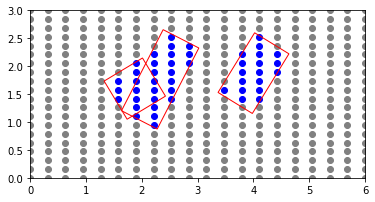

In [8]:
## Multi-boxes to halfspace intersection
def get_vertices_from_centers_and_lws(centers, thetas, lws):
    C = np.cos(thetas)
    S = np.sin(thetas)
    rot11 = np.stack((-C,  S), axis=-1)
    rot12 = np.stack((-S, -C), axis=-1)
    rot21 = np.stack((-C, -S), axis=-1)
    rot22 = np.stack((-S,  C), axis=-1)
    rot31 = np.stack(( C, -S), axis=-1) 
    rot32 = np.stack(( S,  C), axis=-1)
    rot41 = np.stack(( C,  S), axis=-1)
    rot42 = np.stack(( S, -C), axis=-1)
    # Rot has shape (N, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (N, 8)
    disp = 0.5 * np.einsum("...jk, ...k ->...j", Rot, lws)
    # centers has shape (N, 8)
    centers = np.tile(centers, (4,))
    return np.reshape(centers + disp, (-1,4,2))

M = 3
centers = np.random.uniform(low=(1, 1), high=(5, 2), size=(M, 2))
thetas = np.random.uniform(-np.pi, np.pi, size=M)
lws = np.random.uniform(0.5, 2.0, size=(M, 2))
# print(centers.shape, thetas.shape, lws.shape)

vertex_set = get_vertices_from_centers_and_lws(centers, thetas, lws)
As, bs = [], []
for vertices in vertex_set: 
    _A, _b = vertices_to_halfspace_representation(vertices)
    As.append(_A); bs.append(_b)
As = np.stack(As); bs = np.stack(bs)

# produce a a grid of 2D points covering the [0, 6] x [0, 3] grid as shape (N^2, 2)
N = 20
X = np.linspace(0, 6, N)
Y = np.linspace(0, 3, N)
X = np.stack(np.meshgrid(X, Y)).reshape(2, -1).T

print(As.shape, bs.shape)

ax = plt.gca()
# T has shape (M, N^2, 4)
T = np.einsum("ij,...jk->...ik", X, As.swapaxes(1, 2))
T = T.swapaxes(0, 1) <= bs
T = np.all(T, axis=-1)
T1 = np.any(T, axis=-1)
Z1 = X[T1]
ax.scatter(Z1.T[0], Z1.T[1], color='b')
T2 = np.all(~T, axis=-1)
Z2 = X[T2]
ax.scatter(Z2.T[0], Z2.T[1], color='grey')

ax.set_aspect('equal')
ax.set_xlim([0, 6])
ax.set_ylim([0, 3])

for vertices in vertex_set:
    patch = patches.Polygon(vertices, fill=False, color='r')
    ax.add_patch(patch)

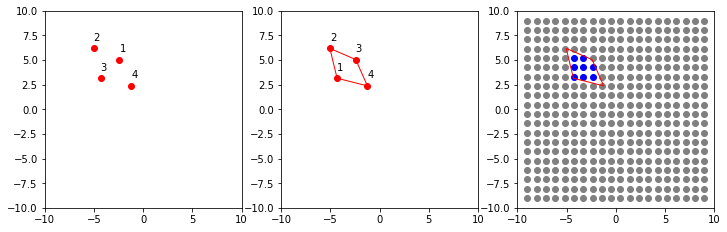

In [14]:
# reorder the vertices of the polytope to use `util.npu.vertices_to_halfspace_representation()`

def order_polytope_vertices(vertices):
    mean = np.mean(vertices, axis=0)
    direction = vertices - mean
    dot = np.dot(direction, direction[0])
    norm = np.linalg.norm(direction, axis=-1) * np.linalg.norm(direction[0])
    dot_norm = np.clip(dot / norm, -0.99999, 0.99999)
    cos = np.arccos(dot_norm)
    sgn = np.sign(np.cross(direction, direction[0]))
    sgn[sgn == 0] = 1
    cos = sgn*cos
    indices = np.argsort(cos)
    return vertices[indices]

theta = np.pi / 4
M = util.npu.rotation_2d(theta)
loc = np.random.uniform(low=-5, high=5, size=2)
l_r_u_d = np.array([
    [-1,  0],
    [ 1,  0],
    [ 0,  1],
    [ 0, -1],
])
scales = np.random.uniform(low=1, high=5, size=4)
l_r_u_d = (l_r_u_d.T * scales).T @ M.T
l, r, u, d = l_r_u_d
vertices = np.stack((loc + l, loc + r, loc + u, loc + d,))
indices = np.random.rand(vertices.shape[0]).argsort()
vertices = vertices[indices]

fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes = axes.ravel()
ax = axes[0]
ax.scatter(*vertices.T, color="r")
for idx, (x, y) in enumerate(vertices):
    ax.text(x, y + 0.8, idx + 1)
    
vertices = order_polytope_vertices(vertices)

ax = axes[1]
ax.scatter(*vertices.T, color="r")
for idx, (x, y) in enumerate(vertices):
    ax.text(x, y + 0.8, idx + 1)

A, b = util.npu.vertices_to_halfspace_representation(vertices)

for ax in [axes[1], axes[2]]:
    util.npu.plot_h_polyhedron(ax, A, b, fc="none", ec='r', ls=None, alpha=1)

# produce a a grid of 2D points covering the [-9, 9]^2 grid as shape (N^2, 2)
N = 20
X = np.linspace(-9, 9, N)
X = np.stack(np.meshgrid(X, X)).reshape(2, -1).T

ax = axes[2]
# check containment
T = np.all(X @ A.T <= b, axis=-1)
Z1 = X[T]
ax.scatter(Z1.T[0], Z1.T[1], color='b')
T = np.any(X @ A.T > b, axis=-1)
Z2 = X[T]
ax.scatter(Z2.T[0], Z2.T[1], color='grey')

for ax in axes:
    ax.set_xlim([-10, 10])
    ax.set_ylim([-10, 10])
    ax.set_aspect('equal')

0.013159667601150732 <= 0.05 ? True


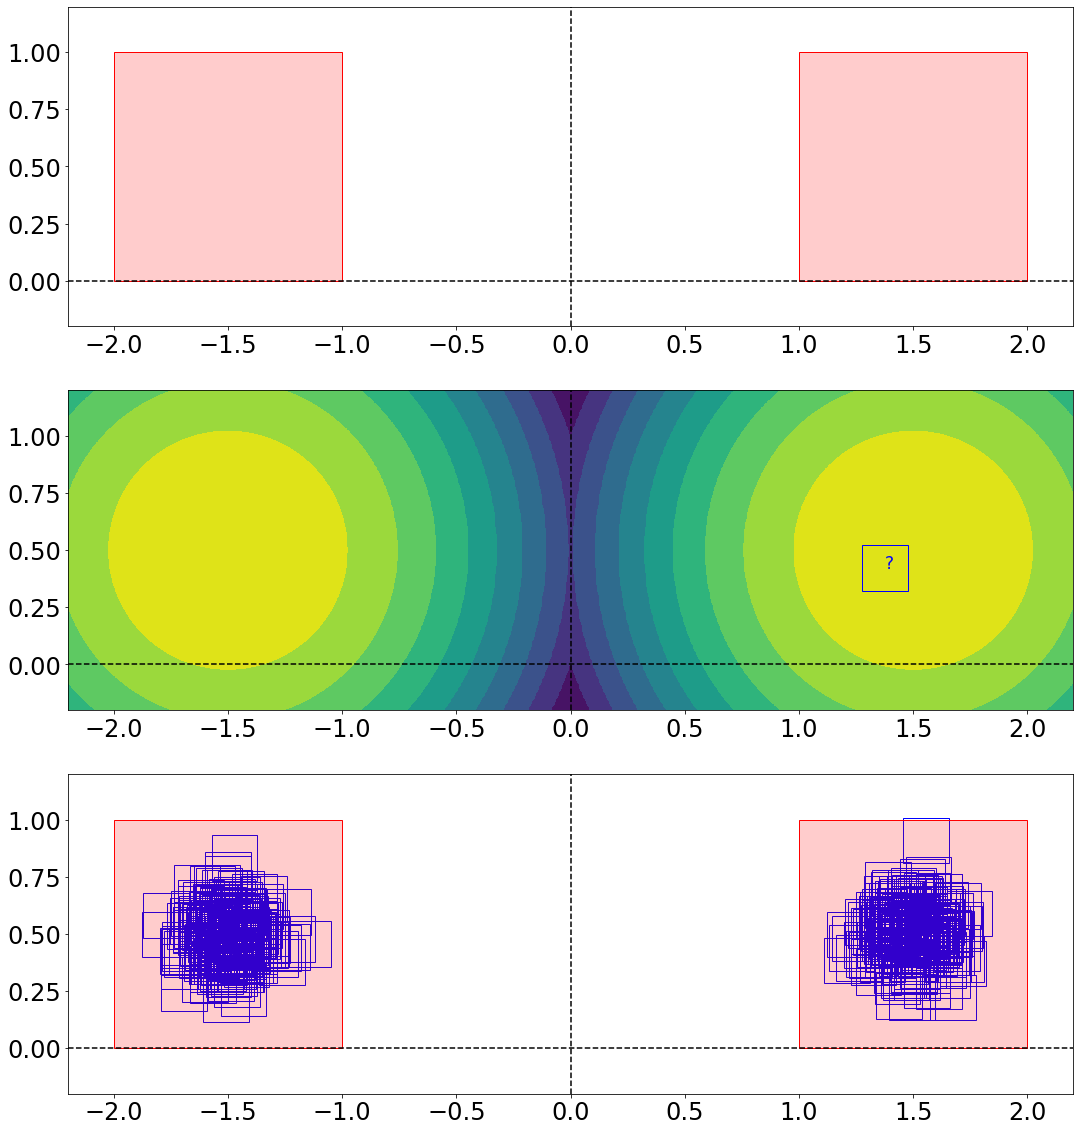

In [33]:
## Sampling example used for a presentation
N = 380
cov = np.array([[0.01, 0],[0, 0.01]])
mean1 = [1.5, 0.5]
dist1 = scipy.stats.multivariate_normal(mean1, cov)
mean2 = [-1.5, 0.5]
dist2 = scipy.stats.multivariate_normal(mean2, cov)

fig, axes = plt.subplots(3,1, figsize=(20, 20))

ax = axes[1]

M = 300
X = np.linspace(-2.2, 2.2, M)
Y = np.linspace(-0.2, 1.2, M)
X, Y = np.meshgrid(X, Y)
Z = np.stack((X, Y,), axis=-1)
PDF1 = dist1.pdf(Z)
PDF2 = dist2.pdf(Z)
PDF = (0.5*PDF1 + 0.5*PDF2)
contour = ax.contourf(X, Y, PDF, locator=ticker.LogLocator(numticks=10))
# ax.clabel(contour, inline=True, fontsize=10)
ax.set_aspect('equal')
ax.axhline(c='k', ms=1, ls='--')
ax.axvline(c='k', ms=1, ls='--')
ax.set_xlim([-2.2,2.2])
ax.set_ylim([-0.2,1.2])

center = dist1.rvs(1)
vertex_set = get_vertices_from_centers([center], [0], [0.2, 0.2])
patch = patches.Polygon(vertex_set[0], fill=False, color='b')
ax.add_patch(patch)
ax.text(*center, '?', size='xx-large', c='b')

ax = axes[2]

centers = np.concatenate((dist1.rvs(N // 2), dist2.rvs(N // 2)))
vertex_set = get_vertices_from_centers(centers, np.zeros(N), [0.2, 0.2])
for vertices in vertex_set:
    patch = patches.Polygon(vertices, fill=False, color='b')
    ax.add_patch(patch)
# samples = samples.T
# ax.scatter(samples[0], samples[1], c='b', s=1)

for ax in [axes[0], axes[2]]:
    poly1 = np.array([
            [1,0],
            [2,0],
            [2,1],
            [1,1]])
    patch = patches.Polygon(poly1, fill=True, fc=(1, 0, 0, 0.2), color='r')
    ax.add_patch(patch)
    poly2 = np.array([
            [-1,0],
            [-2,0],
            [-2,1],
            [-1,1]])
    patch = patches.Polygon(poly2, fill=True, fc=(1, 0, 0, 0.2), color='r')
    ax.add_patch(patch)
    ax.set_aspect('equal')
    ax.axhline(c='k', ms=1, ls='--')
    ax.axvline(c='k', ms=1, ls='--')
    ax.set_xlim([-2.2,2.2])
    ax.set_ylim([-0.2,1.2])

eps = 0.1
rv = scipy.stats.binom(N // 2, eps / 2.)
n_c = 4
PMF = rv.pmf(np.arange(n_c))
beta = 0.1
print(np.sum(PMF), "<=", beta /2, "?", np.sum(PMF) <= beta /2)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=24)

# print(N, "optimal solution is feasible with probability at least", 1 - 2**8 * np.sum(PMF))

# Find value of PDF of dist1 at the origin
# dist1.pdf([0, 0])

(7,) (7, 2)


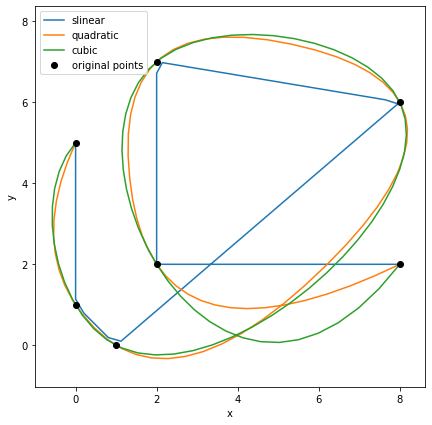

In [6]:
## Interpolating curves from points.
## This works if the points do not have duplicates, and there are at least 3 points
## Taken from:
## https://stackoverflow.com/questions/52014197/how-to-interpolate-a-2d-curve-in-python

points = np.array([[0, 0, 1, 8, 2, 2, 8],
                   [5, 1, 0, 6, 7, 2, 2]]).T

# Linear length along the line:
distance = np.cumsum( np.sqrt(np.sum( np.diff(points, axis=0)**2, axis=1 )) )
distance = np.insert(distance, 0, 0)/distance[-1]

# Interpolation for different methods:
interpolations_methods = ['slinear', 'quadratic', 'cubic']
alpha = np.linspace(0, 1, 75)

interpolated_points = {}
print(distance.shape, points.shape)
for method in interpolations_methods:
    interpolator =  scipy.interpolate.interp1d(distance, points, kind=method, axis=0)
    interpolated_points[method] = interpolator(alpha)

# Graph:
plt.figure(figsize=(7,7))
for method_name, curve in interpolated_points.items():
    plt.plot(*curve.T, '-', label=method_name);

plt.plot(*points.T, 'ok', label='original points');
plt.axis('equal'); plt.legend(); plt.xlabel('x'); plt.ylabel('y');

In [75]:
# TODO: get contour plot of Cholesky matrix

def cholesky_mv_gaussian(pos, mu, L, is_log_prob=False):
    """Compute the discretized PDF of a multivariate Gaussian given its Cholesky decomposition.
    Parameters
    ==========
    pos : np.array
        The coordinate points of a multidmensional cartesian grid with shape (n_x,n_y,2)
        used to retrieve the discretized PDF at those points.
        For example the pos array from a 2D cartesian grid is:
        ```
        X = np.linspace(extent[0,0], extent[0,1], N)
        Y = np.linspace(extent[1,0], extent[1,1], N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        ```
    mu : np.array
        Mean of multivariate Gaussian.
    L : np.array
        Cholesky matrix of covariance matrix Sigma of multivariate Gaussian, namely Sigma = L L^T.
    
    Returns
    =======
    np.array
        The values of the PDF at the coordinate points with shape (n_x,n_y).
    """
    n = mu.size
    L_inv = np.linalg.inv(L)
    _p = -0.5*n*np.log(2*np.pi) - np.sum(np.log(np.diag(L)))
    _w = np.einsum("jk, ...k ->...j", L_inv, pos - mu)
    _w = -0.5*np.linalg.norm(_w, axis=-1)**2
    _p = _p + _w
    if is_log_prob:
        return _p
    else:
        return np.exp(_p)

def cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls):
    _p = np.zeros(pos.shape[:2])
    for (log_pi, mu, L) in zip(log_pis, mus, Ls):
        _w = cholesky_mv_gaussian(pos, mu, L, is_log_prob=True)
        _p += np.exp(log_pi + _w)
    return _p

ph = 6
mus = np.zeros((ph, 2))

In [33]:
# Two ways of computing the binomial distribution.
# https://en.wikipedia.org/wiki/Binomial_distribution
eps = 0.1
N = 10
n = 3
ids = np.arange(n)
combs = scipy.special.binom(N, ids).astype(int)
eps_1 = np.power(eps, ids)
eps_2 = np.power(1. - eps, N - ids)
pmf = combs * eps_1 * eps_2
cdf = np.sum(pmf)

rv = scipy.stats.binom(N, eps)
pmf, rv.pmf(ids), cdf, rv.cdf(n - 1)

(array([0.34867844, 0.38742049, 0.19371024]),
 array([0.34867844, 0.38742049, 0.19371024]),
 0.9298091736000003,
 0.9298091736)

In [2]:
# generating the binomial coefficent in few lines
# 1
# 1 1
# 1 2 1
# 1 3 3 1
# 1 4 6 4 1
# 1 5 10 10 5 1
# It seems better to use scipy.special.binom() over scipy.special.comb()
# scipy.special.binom() returns arrays of floats
n = np.array(sum([[i for j in range(i+1)] for i in range(5)], start=[]))
k = np.array(sum([[j for j in range(i+1)] for i in range(5)], start=[]))
n, k, scipy.special.binom(n, k).astype(int)

(array([0, 1, 1, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 4]),
 array([0, 0, 1, 0, 1, 2, 0, 1, 2, 3, 0, 1, 2, 3, 4]),
 array([1, 1, 1, 1, 2, 1, 1, 3, 3, 1, 1, 4, 6, 4, 1]))

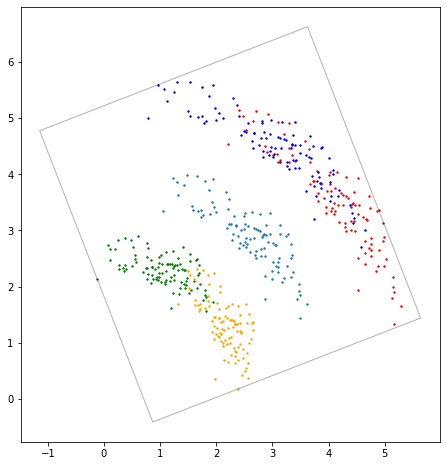

In [8]:
# Forming quadrilateral enclosing vertices of box.

def get_vertices_from_center(center, heading, lw):
    vertices = np.empty((8,))
    rot1 = np.array([
            [ np.cos(heading),  np.sin(heading)],
            [ np.sin(heading), -np.cos(heading)]])
    rot2 = np.array([
            [ np.cos(heading), -np.sin(heading)],
            [ np.sin(heading),  np.cos(heading)]])
    rot3 = np.array([
            [-np.cos(heading), -np.sin(heading)],
            [-np.sin(heading),  np.cos(heading)]])
    rot4 = np.array([
            [-np.cos(heading),  np.sin(heading)],
            [-np.sin(heading), -np.cos(heading)]])
    vertices[0:2] = center + 0.5 * rot1 @ lw
    vertices[2:4] = center + 0.5 * rot2 @ lw
    vertices[4:6] = center + 0.5 * rot3 @ lw
    vertices[6:8] = center + 0.5 * rot4 @ lw
    return vertices

def get_approx_union(theta, vertices):
    """Gets A_t, b_0 for the contraint set A_t x >= b_0
    vertices : np.array
        Vertices of shape (?, 8)
    
    Returns
    =======
    np.array
        A_t matrix of shape (4, 2)
    np.array
        b_0 vector of shape (4,)
    """
    At = np.array([
            [ np.cos(theta), np.sin(theta)],
            [-np.sin(theta), np.cos(theta)]])
    At = np.concatenate((np.eye(2), -np.eye(2),)) @ At

    a0 = np.max(At @ vertices[:, 0:2].T, axis=1)
    a1 = np.max(At @ vertices[:, 2:4].T, axis=1)
    a2 = np.max(At @ vertices[:, 4:6].T, axis=1)
    a3 = np.max(At @ vertices[:, 6:8].T, axis=1)
    b0 = np.max(np.stack((a0, a1, a2, a3)), axis=0)
    return At, b0

def plot_h_polyhedron(ax, A, b, fc='none', ec='none', alpha=0.3):
    """
    A x < b is the H-representation
    [A; b], A x + b < 0 is the format for HalfspaceIntersection
    """
    Ab = np.concatenate((A, -b[...,None],), axis=-1)
    res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2],
                                 bounds=(None, None))
    hs = scipy.spatial.HalfspaceIntersection(Ab, res.x)
    ch = scipy.spatial.ConvexHull(hs.intersections)
    x, y = zip(*hs.intersections[ch.vertices])
    ax.fill(x, y, fc=fc, ec=ec, alpha=0.3)

N = 100
lw = np.array([3.0, 1.5])
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = (1/8 * np.pi) * z + np.pi + np.random.uniform(0., 2.)*np.pi
r = np.random.normal(loc=4., scale=0.2, size=(N,))
X = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)


fig, ax = plt.subplots(figsize=(15,8))
axes = [ax]

axes[0].scatter(X[:,0], X[:,1], s=2)
axes[0].set_aspect('equal')

vertex_set = np.zeros((N, 8))
for idx in range(N):
    vertex_set[idx] = get_vertices_from_center(X[idx,:2], X[idx,2], lw)

X = vertex_set[:,0:2].T
axes[0].scatter(X[0], X[1], c='r', s=2)
X = vertex_set[:,2:4].T
axes[0].scatter(X[0], X[1], c='b', s=2)
X = vertex_set[:,4:6].T
axes[0].scatter(X[0], X[1], c='g', s=2)
X = vertex_set[:,6:8].T
axes[0].scatter(X[0], X[1], c='orange', s=2)
axes[0].set_aspect('equal')

"""Cluster the samples"""
mean_theta = np.mean(X[:,2])
A, b = get_approx_union(mean_theta, vertex_set)

plot_h_polyhedron(axes[0], A, b, ec='k', alpha=0.3)

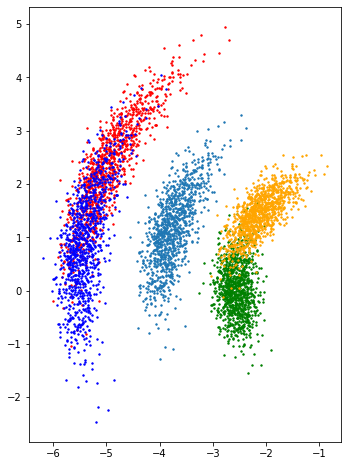

In [3]:
# Forming quadrilateral enclosing vertices of box using broadcasts.

def get_vertices_from_centers(centers, thetas, lw):
    C = np.cos(thetas)
    S = np.sin(thetas)
    rot11 = np.stack(( C,  S), axis=-1)
    rot12 = np.stack(( S, -C), axis=-1)
    rot21 = np.stack(( C, -S), axis=-1) 
    rot22 = np.stack(( S,  C), axis=-1)
    rot31 = np.stack((-C, -S), axis=-1)
    rot32 = np.stack((-S,  C), axis=-1)
    rot41 = np.stack((-C,  S), axis=-1)
    rot42 = np.stack((-S, -C), axis=-1)
    # Rot has shape (N, 8, 2)
    Rot = np.stack((rot11, rot12, rot21, rot22, rot31, rot32, rot41, rot42), axis=1)
    # disp has shape (N, 8)
    disp = 0.5 * Rot @ lw
    # centers has shape (N, 8)
    centers = np.tile(centers, (4,))
    return np.reshape(centers + disp, (-1,4,2))

N = 1000
lw = np.array([3.0, 1.5])
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = (1/8 * np.pi) * z + np.pi + np.random.uniform(0., 2.)*np.pi
r = np.random.normal(loc=4., scale=0.2, size=(N,))
X = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)


fig, ax = plt.subplots(figsize=(15,8))
axes = [ax]

axes[0].scatter(X[:,0], X[:,1], s=2)
vertex_set = get_vertices_from_centers(X[:,:2], X[:, 2], lw)

Z = vertex_set[:,0].T
axes[0].scatter(Z[0], Z[1], c='r', s=2)
Z = vertex_set[:,1].T
axes[0].scatter(Z[0], Z[1], c='b', s=2)
Z = vertex_set[:,2].T
axes[0].scatter(Z[0], Z[1], c='g', s=2)
Z = vertex_set[:,3].T
axes[0].scatter(Z[0], Z[1], c='orange', s=2)
axes[0].set_aspect('equal')

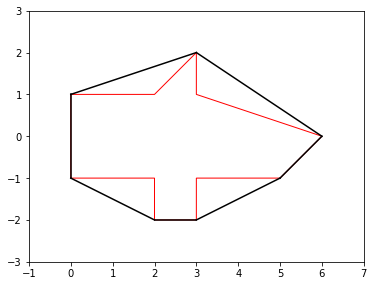

In [28]:
# Convex hull from polytope
# TODO: figure out how to find the largest inner convex hull.
poly = np.array([
    [  0, -1],
    [  2, -1],
    [  2, -2],
    [  3, -2],
    [  3, -1],
    [  5, -1],
    [  6,  0],
    [  3,  1],
    [  3,  2],
    [  2,  1],
    [  0,  1]])

fig, ax = plt.subplots(figsize=(6,6))

patch = patches.Polygon(poly, fill=False, color='r')
ax.add_patch(patch)
extent = np.concatenate([np.min(poly, axis=0), np.max(poly, axis=0)])

ax.set_xlim([extent[0] - 1, extent[2] + 1])
ax.set_ylim([extent[1] - 1, extent[3] + 1])
ax.set_aspect('equal')

ch = scipy.spatial.ConvexHull(poly, incremental=False, qhull_options=None)

for simplex in ch.simplices:
    ax.plot(poly[simplex, 0], poly[simplex, 1], 'k-')

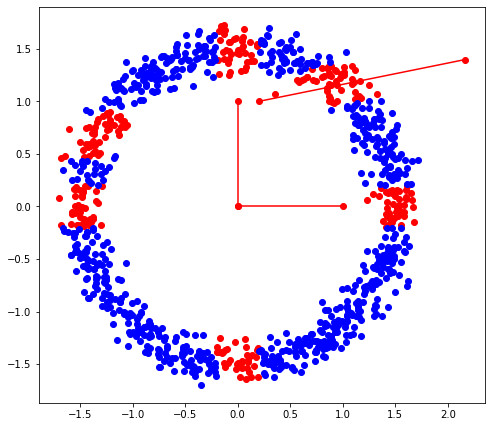

In [42]:
# Distance from line 
fig, ax = plt.subplots(figsize=(8, 8))

def distance_from_line_2d(points, x_start, y_start, x_end, y_end):
    """Get the distances from each point to a line spanned by line segment from
    (x_start, y_start) to (x_end, y_end). Works for horizontal and vertical lines.
    
    Parameters
    ==========
    points : np.array
        2D points of shape (n, 2)
    x_start : float
        Line segment component
    y_start : float
        Line segment component
    x_end : float
        Line segment component
    y_end : float
        Line segment component
    """
    return np.abs((x_end - x_start)*(y_start - points[:, 1]) - (x_start - points[:, 0])*(y_end - y_start)) \
            / np.sqrt((x_end - x_start)**2 + (y_end - y_start)**2)

TOL = 0.2
N = 1000
z = np.random.normal(loc=0., scale=0.5, size=(N,))
theta = 2 * np.pi * z
r = np.random.normal(loc=1.5, scale=0.1, size=(N,))
points = np.stack((r*np.cos(theta), r*np.sin(theta), theta), axis=1)

x_start, y_start = 0.2, 1.0
angle, radius = 0.2, 2
x_end, y_end = x_start + radius*np.cos(angle), y_start + radius*np.sin(angle)
S1 = np.array([[x_start, y_start], [x_end, y_end]])
distances = distance_from_line_2d(points, x_start, y_start, x_end, y_end)
mask_1 = distances < TOL
distances = distance_from_line_2d(points, 0, 0, 1, 0)
mask_2 = distances < TOL
distances = distance_from_line_2d(points, 0, 0, 0, 1)
mask_3 = distances < TOL

mask_and = mask_1 | mask_2 | mask_3
mask_not = ~mask_and

# plot line segments
ax.plot(S1[:,0], S1[:,1], '-ro')
ax.plot([0, 1], [0, 0], '-ro')
ax.plot([0, 0], [0, 1], '-ro')

ax.scatter(points[mask_and,0], points[mask_and,1], c='r')
ax.scatter(points[mask_not,0], points[mask_not,1], c='b')
ax.set_aspect('equal')

Text(0.5, 1.0, 'Radian angles reflected about y-axis')

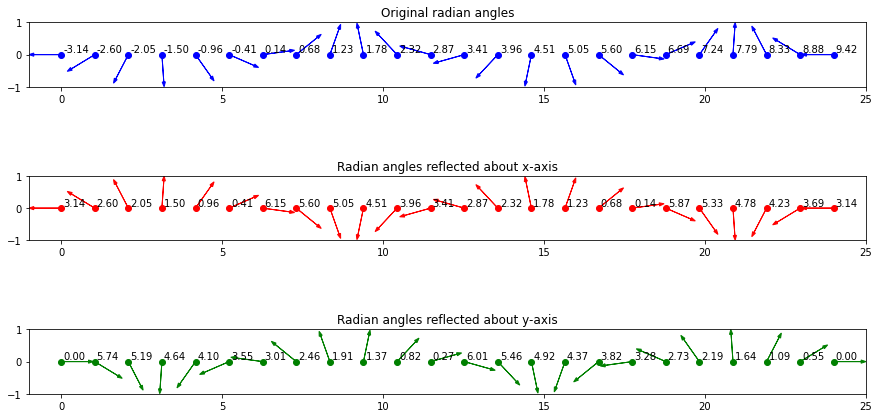

In [6]:
# Reflecting radian angles
n = 24
rs = np.linspace(-np.pi, 3*np.pi, n)
xs = np.linspace(0, n, n)

def plot_arrows(ax, xs, rs, color='b'):
    ax.scatter(xs, np.zeros(xs.shape), color=color)
    for i in range(n):
        x = xs[i]
        y = 0
        r = rs[i]
        rx = np.cos(r)
        ry = np.sin(r)
        ax.arrow(x, y, rx, ry, head_width=0.1, length_includes_head=True, color=color)
        ax.text(x + 0.06, y + 0.06, "{:.2f}".format(r))
    ax.set_aspect('equal')
    ax.set_xlim([-1, xs[-1] + 1])
    ax.set_ylim([-1, 1])

fig, axes = plt.subplots(3, 1, figsize=(15,8))
axes = axes.ravel()
plot_arrows(axes[0], xs, rs, color='b')
axes[0].set_title("Original radian angles")

def reflect_radians_about_x_axis(r):
    r = (-r) % (2*np.pi)
    return r

plot_arrows(axes[1], xs, reflect_radians_about_x_axis(rs), color='r')
axes[1].set_title("Radian angles reflected about x-axis")

def reflect_radians_about_y_axis(r):
    r = (np.pi - r) % (2*np.pi)
    return r

plot_arrows(axes[2], xs, reflect_radians_about_y_axis(rs), color='g')
axes[2].set_title("Radian angles reflected about y-axis")

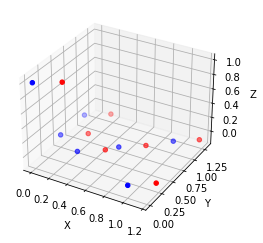

In [4]:
# translate points using transformation matrix
def create_translation_mtx(x, y, z):
    return np.array([
            [1, 0, 0, x],
            [0, 1, 0, y],
            [0, 0, 1, z],
            [0, 0, 0, 1]])

points = np.array([
    [0,  1,  0],
    [1,  0,  0],
    [0,  0,  1],
    [1,  1,  0],
    [0.3,0.3,0],
    [0.6,0.6,0],
    [0,  0.5,0],])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

points = points.T
ax.scatter(points[0], points[1], points[2], c='blue')
points = points.T

mtx = create_translation_mtx(0.15, 0.3, -0.1)
points = np.pad(points, [(0, 0), (0, 1)], mode='constant', constant_values=1)
points = (mtx @ points.T).T
points = points[:,:3]

points = points.T
ax.scatter(points[0], points[1], points[2], c='red')
points = points.T

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
None

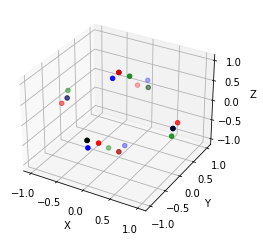

In [5]:
# translate points using transformation matrix
def create_x_rotation_mtx(a):
    """a is roll"""
    return np.array([
            [1, 0,          0,         0],
            [0, np.cos(a), -np.sin(a), 0],
            [0, np.sin(a),  np.cos(a), 0],
            [0, 0,          0,         1]])

def create_y_rotation_mtx(b):
    """b is pitch"""
    return np.array([
            [ np.cos(b), 0, np.sin(b), 0],
            [ 0,         1, 0,         0],
            [-np.sin(b), 0, np.cos(b), 0],
            [ 0,         0, 0,         1]])

def create_z_rotation_mtx(c):
    """c is yaw"""
    return np.array([
            [np.cos(c), -np.sin(c), 0, 0],
            [np.sin(c),  np.cos(c), 0, 0],
            [0,          0,         1, 0],
            [0,          0,         0, 1]])

points = np.array([
    [ 0,   1,  0],
    [ 1,   0,  0],
    [ 0,   0,  1],
    [ 0,  -1,  0],
    [-1,  0,   0],
    [ 0,  0,  -1],])

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

mtx = create_z_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='red', marker='o')

mtx = create_x_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='blue', marker='o')

mtx = create_y_rotation_mtx(0.2)
p = np.pad(points, [(0, 0), (0, 1)],
                mode='constant', constant_values=1)
p = (mtx @ p.T).T
p = p[:,:3]

p = p.T
ax.scatter(p[0], p[1], p[2], c='green', marker='o')

points = points.T
ax.scatter(points[0], points[1], points[2], c='black')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
None

(2, 1906) (2, 1890)
(2, 3796)
(72, 96)
(72, 96, 3)


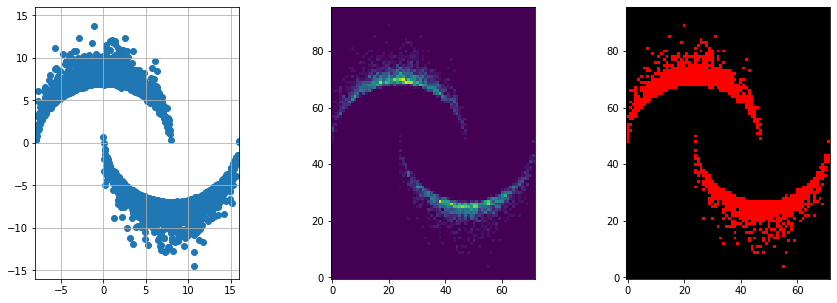

In [6]:
# Generating the two moons dataset
# Forming 2D histograms and 2D bitmaps; plotting histograms and bitmaps

N = 2000
sz = 8
sigma = 0.7
x = np.random.normal(loc=0., scale=sz / 2., size=(N,))
x = x[x**2 < sz**2]
y = np.sqrt(sz**2 - x**2) \
        + np.random.lognormal(mean=0, sigma=sigma, size=(x.size,)) \
        - np.exp(sigma**2 / 2.)
X1 = np.array([x, y])
X = X1

x = np.random.normal(loc=0., scale=sz / 2., size=(N,)) + sz
x = x[(x - sz)**2 < sz**2]
y = -np.sqrt(sz**2 - (x - sz)**2) \
        - np.random.lognormal(mean=0., sigma=sigma, size=(x.size,)) \
        + np.exp(sigma**2 / 2.)
X2 = np.array([x, y])
X = np.concatenate((X1, X2), axis=1)
print(X1.shape, X2.shape)
print(X.shape)

x_min = int(-sz)
x_max = int(2*sz)
y_min = int(-2*sz)
y_max = int(2*sz)

fig, axes = plt.subplots(1,3, figsize=(15,5))
axes = axes.T
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
hist, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])
print(hist.shape)
axes[1].imshow(hist.T, origin='lower', interpolation='none')
bitmap = hist.copy()
# Create and display bitmap
bitmap[bitmap > 0.] = 255.
bitmap = np.stack((bitmap, np.zeros(bitmap.shape), np.zeros(bitmap.shape)), axis=-1)
bitmap = bitmap.astype(np.uint8)
print(bitmap.shape)
# Axes.show() expects (M, N, 3): an image with RGB values (0-1 float or 0-255 int)
axes[2].imshow(bitmap.swapaxes(0, 1), origin='lower', interpolation='none')

In [7]:
# Cartesian product of multiple arrays

# Based on:
# https://stackoverflow.com/questions/11144513/cartesian-product-of-x-and-y-array-points-into-single-array-of-2d-points

def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)

x = [np.arange(3), np.arange(2) + 1, np.arange(2) - 1]
print(x)
print()
print( cartesian_product(*x) )
print()

# Cartesian product of two arrays
x, y = x[0], x[1]
print(np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))]))

[array([0, 1, 2]), array([1, 2]), array([-1,  0])]

[[ 0  1 -1]
 [ 0  1  0]
 [ 0  2 -1]
 [ 0  2  0]
 [ 1  1 -1]
 [ 1  1  0]
 [ 1  2 -1]
 [ 1  2  0]
 [ 2  1 -1]
 [ 2  1  0]
 [ 2  2 -1]
 [ 2  2  0]]

[[0 1]
 [1 1]
 [2 1]
 [0 2]
 [1 2]
 [2 2]]


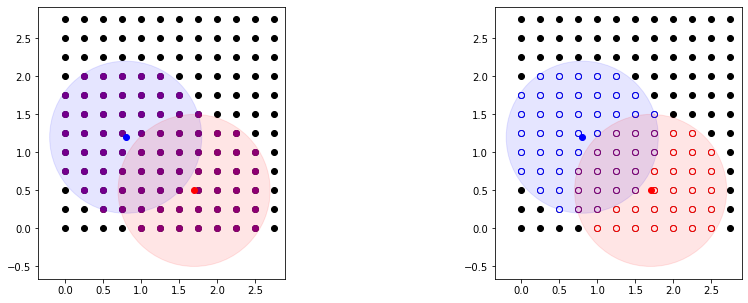

In [8]:
# select points in X that are unit 1 close to points in Y
# uses scipy.spatial.distance_matrix()
N = 12
x, y = np.arange(N) / 4., np.arange(N) / 4.
X = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])

Y = np.array([
    [0.8, 1.2],
    [1.7, 0.5]])

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.ravel()
for ax in axes:
    ax.scatter(X.T[0], X.T[1], c='k')

    circ1 = plt.Circle(Y[0], 1, color='b', alpha=0.1)
    ax.add_patch(circ1)
    ax.plot(Y[0][0], Y[0][1], 'bo')

    circ1 = plt.Circle(Y[1], 1, color='r', alpha=0.1)
    ax.add_patch(circ1)
    ax.plot(Y[1][0], Y[1][1], 'ro')

# dist is a (number of points in X, number of points in Y)
# dist[i, j] is the distance from point X[i] to Y[j] 
dist = scipy.spatial.distance_matrix(X, Y)
mask = np.min(dist, axis=1) < 1
K = X[mask]
axes[0].scatter(K.T[0], K.T[1], c='purple')
blue_mask = np.logical_and(dist[:,0] < 1, dist[:,1] >= 1)
red_mask  = np.logical_and(dist[:,1] < 1, dist[:,0] >= 1)
purple_mask = np.logical_and(dist[:,0] < 1, dist[:,1] < 1)
K = X[blue_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='b')
K = X[red_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='r')
K = X[purple_mask]
axes[1].scatter(K.T[0], K.T[1], facecolors='white', edgecolors='purple')

for ax in axes:
    ax.set_aspect('equal')

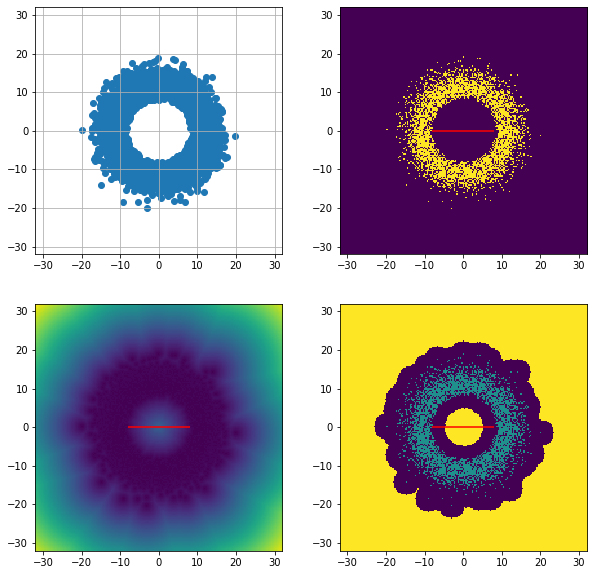

In [9]:
# Generating ring dataset
# Apply distance transform on negative space
n = 5000
r = 8
p = 10
cov = np.array([[p, 0], [0, p]])
X = np.random.multivariate_normal([0, 0], cov, n)
X = X + r*X / np.sqrt(np.square(X).sum(axis=1, keepdims=True))
X = X.T

x_min = -4*r
x_max = 4*r
y_min = -4*r
y_max = 4*r

fig, axes = plt.subplots(2,2, figsize=(10,10))
axes = axes.reshape((-1))
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
bitmap, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])

bitmap[bitmap > 0.] = 1.
axes[1].imshow(bitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[1].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))


nbitmap = -bitmap + 1
# alternatively scipy.ndimage.distance_transform_cdt
dt = scipy.ndimage.distance_transform_edt(nbitmap)
axes[2].imshow(dt.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[2].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))

dist = 10
zbitmap = np.zeros(bitmap.shape)
zbitmap[dt > dist] = 1.
zbitmap[bitmap == 1.] = 0.5
axes[3].imshow(zbitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])
axes[3].add_collection(mc.LineCollection( [((-r,0), (r,0))] , colors='red'))

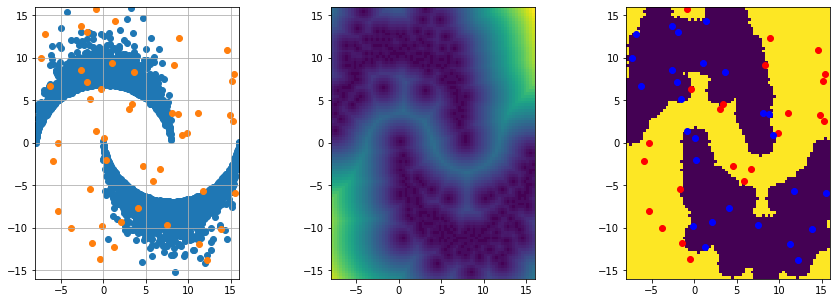

In [10]:
# Generating two moons dataset
# Filtering method that applys distance transform on negative space to select points Y epsilon close to point cloud X.

N = 5000
sz = 8
sigma = 0.7
x = np.random.normal(loc=0., scale=sz / 2., size=(N,))
x = x[x**2 < sz**2]
y = np.sqrt(sz**2 - x**2) \
        + np.random.lognormal(mean=0, sigma=sigma, size=(x.size,)) \
        - np.exp(sigma**2 / 2.)
X1 = np.array([x, y])
X = X1

x = np.random.normal(loc=0., scale=sz / 2., size=(N,)) + sz
x = x[(x - sz)**2 < sz**2]
y = -np.sqrt(sz**2 - (x - sz)**2) \
        - np.random.lognormal(mean=0., sigma=sigma, size=(x.size,)) \
        + np.exp(sigma**2 / 2.)
X2 = np.array([x, y])
X = np.concatenate((X1, X2), axis=1)

x_min = int(-sz)
x_max = int(2*sz)
y_min = int(-2*sz)
y_max = int(2*sz)
x_size = x_max - x_min
y_size = y_max - y_min

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes = axes.reshape((-1))
axes[0].scatter(X[0] ,X[1])
axes[0].set_xlim([x_min, x_max])
axes[0].set_ylim([y_min, y_max])
axes[0].set_aspect('equal')
axes[0].grid()

bins= [
    int( 3*(x_max - x_min) ),
    int( 3*(y_max - y_min) )]

# Create and display histogram
bitmap, xedges, yedges = np.histogram2d(X[0], X[1], bins=bins, range=[[x_min, x_max], [y_min, y_max]])

nbitmap = -bitmap + 1
# alternatively scipy.ndimage.distance_transform_cdt
dt = scipy.ndimage.distance_transform_edt(nbitmap)
axes[1].imshow(dt.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])

dist = 5
zbitmap = np.zeros(bitmap.shape)
zbitmap[dt > dist] = 1.
axes[2].imshow(zbitmap.T, origin='lower', interpolation='none', extent=[x_min, x_max, y_min, y_max])

shift = np.array([x_min, y_min])
Y = np.random.random((50, 2)) @ np.diag([x_size, y_size]) + shift
axes[0].scatter(Y.T[0], Y.T[1])

Yind = ( 3*(Y - shift) ).astype(int)
# alternative value selection
# val = np.array([dt[ids[0], ids[1]] for ids in Yind])
# alternative value selection
# val = dt[tuple(Yind.T)]
val = dt[ Yind.T[0], Yind.T[1] ]

Z = Y[val > dist].T
axes[2].scatter(Z[0], Z[1], c='r')
Z = Y[val <= dist].T
axes[2].scatter(Z[0], Z[1], c='b')

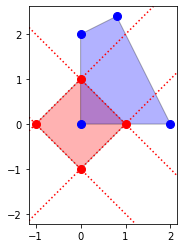

In [17]:
# Get feasible point inside a polyhedron with H-representation, and then find the vertices of the polyhedron
# and then plot the shape of the polygon
# See:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.HalfspaceIntersection.html
# https://www.mpt3.org/Geometry/Sets
from scipy.spatial import HalfspaceIntersection, ConvexHull

# First example
Ab = np.array([
    [-1, 1,-1],
    [ 1, 1,-1],
    [-1,-1,-1],
    [ 1,-1,-1]
])

# A = Ab[:,:2], b = Ab[:,2] and
# the constraint set is formed by Ax + b <= 0

# find any point inside A_ub x <= b_ub
res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2])
# res has attributes x, fun, slack, con, success, status, nit, message

# Use intersections of half-spaces
hs = HalfspaceIntersection(Ab, res.x)
# Use the vertices of the convex hull, which for 2D are guaranteed to be in counterclockwise order
# Otherwise can't plot the polygon properly
ch = ConvexHull(hs.intersections)

fig, ax = plt.subplots()

x, y = zip(*hs.intersections[ch.vertices])
ax.plot(x, y, 'ro', markersize=8)
# patch = matplotlib.patches.Polygon(hs.intersections[ch.vertices], fill=True, color='r', alpha=0.3)
# ax.add_patch(patch)
ax.fill(x, y, fc='r', ec='k',alpha=0.3)

# Plot the boundary lines of halfspaces
A, b = Ab[:,:2], -Ab[:,2]
x0, x1 = 0, 1 # pick 2 points on the x intersection
y0 = b / A[:, 1] - 0*(A[:, 0] / A[:, 1]) # compute y = mx + b
y1 = b / A[:, 1] - 1*(A[:, 0] / A[:, 1])
ax.axline((x0, y0[0]), (x1, y1[0]), c='r', ls=':')
ax.axline((x0, y0[1]), (x1, y1[1]), c='r', ls=':')
ax.axline((x0, y0[2]), (x1, y1[2]), c='r', ls=':')
ax.axline((x0, y0[3]), (x1, y1[3]), c='r', ls=':')

# Second example
Ab = np.array([
        [-1, 0., 0.],
        [0., -1., 0.],
        [2., 1., -4.],
        [-0.5, 1., -2.]])

res = scipy.optimize.linprog([0, 0], A_ub=Ab[:,:2], b_ub=-Ab[:,2])
hs = HalfspaceIntersection(Ab, res.x)
ch = ConvexHull(hs.intersections)

x, y = zip(*hs.intersections[ch.vertices])
ax.plot(x, y, 'bo', markersize=8)
ax.fill(x, y, fc='b', ec='k',alpha=0.3)
ax.set_aspect('equal')

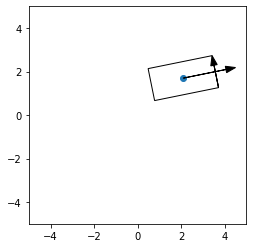

In [21]:
# Boxes and rotation matrices
x = np.array([2.1, 1.7])
lw = np.array([3.0, 1.5])
theta = 0.2 # 
rot1 = np.array([
        [ np.cos(theta),  np.sin(theta)],
        [ np.sin(theta), -np.cos(theta)]])
rot2 = np.array([
        [ np.cos(theta), -np.sin(theta)],
        [ np.sin(theta),  np.cos(theta)]])

rot3 = np.array([
        [-np.cos(theta), -np.sin(theta)],
        [-np.sin(theta),  np.cos(theta)]])
rot4 = np.array([
        [-np.cos(theta),  np.sin(theta)],
        [-np.sin(theta), -np.cos(theta)]])

vertices = np.empty((8,))
vertices[0:2] = x + 0.5 * rot1 @ lw
vertices[2:4] = x + 0.5 * rot2 @ lw
vertices[4:6] = x + 0.5 * rot3 @ lw
vertices[6:8] = x + 0.5 * rot4 @ lw

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.scatter(x[0], x[1])
ax.arrow(*x, 2*np.cos(theta), 2*np.sin(theta), head_width=0.3, color='k')
bb = patches.Polygon(vertices.reshape((-1,2,)), closed=True, color='k', fc='none')

dx = vertices[2:4] - vertices[0:2]
ax.arrow(vertices[0], vertices[1], dx[0], dx[1], length_includes_head=True, head_width=0.3, color='k')
ax.add_patch(bb)
ax.set_xlim([-5,5])
ax.set_ylim([-5,5])
None

## Scratch

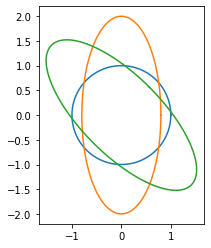

In [3]:
# Map a circle to a rotated ellipse

# generate points in unit circle
theta = np.linspace(0,2*np.pi, 100)
X = np.array([np.cos(theta), np.sin(theta)])

# plot unit circle
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.plot(X[0], X[1])

# map the unit circle to ellipse using 2x2 matrix
A = np.array([[0.8, 0], [0, 2]])
Z = A @ X
ax.plot(Z[0], Z[1])

theta = np.pi / 4
A = np.array([[0.8, 0], [0, 2]])
R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta),  np.cos(theta)]])
W = R @ A @ X
ax.plot(W[0], W[1])

None